# 第五回AI<画像/GPT>技術者育成講座
目次
- OpenAI APIのインストール
- 環境変数の設定
- 関数の定義
- 課題例①
- 課題例②

注意点
- この演習はGoogle Colaboratyで実行することを想定しています

## OpenAI APIのインストール (+必要なライブラリをインストール)

---


- [公式ドキュメント](https://platform.openai.com/docs/api-reference?lang=python)
- [GitHub](https://github.com/openai/openai-python)

In [ ]:
# ライブラリのインストール
!pip install openai==1.54.3

In [ ]:
# グラフを日本語フォントに対応させるライブラリ
!pip install japanize-matplotlib

## 環境変数の設定
左のタブの`シークレット`から`OPENAI_API_KEY`を設定


<img width=500 src="https://github.com/HarmoLab/aitr/blob/main/2023/exercise_04/colab_secret.png?raw=true">

## 使用する関数の定義

In [3]:
import time

import pandas as pd
from google.colab import userdata
from openai import OpenAI
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

client = OpenAI(
    api_key= userdata.get('OPENAI_API_KEY')
)

In [4]:
# promptから料金を出力する関数
def calculate_credit(model:str, input_tokens:int, output_tokens:int) -> float:
    yen_rate = 150 # $1 = 150円で計算
    if model == "gpt-4o-mini-2024-07-18":
        input_credit = (0.0015 * yen_rate) / 1000
        output_credit = (0.003 * yen_rate) / 1000
    elif model == "gpt-4o-2024-08-06":
        input_credit = (0.0025 * yen_rate) / 1000
        output_credit = (0.01 * yen_rate) / 1000
    else:
        assert False, f"モデル名: {model}の料金計算はできません。modelは'gpt-4o-2024-08-06',または'gpt-4o-mini-2024-07-18'を使用してください。"
    total_credit = round(input_credit * input_tokens + output_credit * output_tokens, 2)
    print(f"使用したモデル: {model}, 料金: {total_credit}円")
    return total_credit

In [6]:
# forでループするために関数化 (RateLimit対策のためtenacityのデコーダを採用)
# 参考: https://cookbook.openai.com/examples/how_to_handle_rate_limits
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def simple_completion(model_name:str, system_prompt:str, user_prompt:str):
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt
            },
        ],
        model=model_name,
        timeout=15
    )
    # 料金の計算
    credit = calculate_credit(model_name, response.usage.prompt_tokens, response.usage.completion_tokens)
    return response, credit

### chat.completions.createに使用する引数について
公式ドキュメント: https://platform.openai.com/docs/api-reference/chat/create

### 主要な引数
- model (必須)
    - 使用する学習モデル (本演習では"gpt-4o-mini-2024-07-18"または"gpt-4o-2024-08-06"を使用)
- messages (必須)
    - role
        - system: アシスタントの動作を設定
        - assistant: アシスタントの望ましい動作を設定 (ユーザも作成可)
        - user: ユーザの指示
    - content
        - roleに対して入力する文章
- max_tokens: int or null
    - 生成するトークンの最大数。出力の長さを制限することが可能
- n: int or null
    - 生成するレスポンスの数 (デフォルト: 1)
- temperature: number or null
    - 0～2の間で指定
    - 0に近づくにつれて決定論的になり、2に近づくにつれて生成文が多様でランダムになる（デフォルト: 1）
        - 詳しい説明: https://techblog.a-tm.co.jp/entry/2023/04/24/181232

## 演習課題例①: **Amazonのレビュー分類**
- 今回使用するデータセット (前回演習と同じデータ)
    - Amazon Reviews Multi:
https://huggingface.co/datasets/mteb/amazon_reviews_multi/viewer/ja

In [ ]:
!pip install datasets

In [ ]:
import datasets
# Amazonレビューのデータセット(日本語)をダウンロード
# 今回はダウンロード時間を減らすために検証データ (validation)のみ取得
dataset = datasets.load_dataset("mteb/amazon_reviews_multi", "ja", split="validation")
print(dataset)

### データの用意

In [ ]:
k = 10 # 10件のレビュー文に対する評価
shuffled_dataset = dataset.shuffle(seed=70) # データセットをシャッフル

# 検証データ
review_list = shuffled_dataset[:k]["text"]
label_list = shuffled_dataset[:k]["label"]

# few-shotデータ
num_few_shot = 4  # few-shotの数
review_list_few_shot = shuffled_dataset[k: k + num_few_shot]["text"]
label_list_few_shot = shuffled_dataset[k: k + num_few_shot]["label"]

# テストデータ
test_review_list = shuffled_dataset[-k:]["text"]
test_label_list = shuffled_dataset[-k:]["label"]


print(review_list)
print(label_list)

### 検証データによる評価

* 最も性能が良いプロンプトを見つける

#### zero-shotプロンプトを使用したレビューの分類

* 検証データを用いたレビュー分類
* 回答例を与えないzero-shotプロンプトを使用

In [ ]:
# 以下のsystem prompt (zero-shotプロンプト) を用いたレビュー分類
system_prompt = """
レビュー文を0から4までの整数に分類してください。
"""

# 使用するモデルの設定
model = "gpt-4o-mini-2024-07-18"

predict_label_list = [] # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(review_list, label_list)):
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(review)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(model, system_prompt, review)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")

In [ ]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

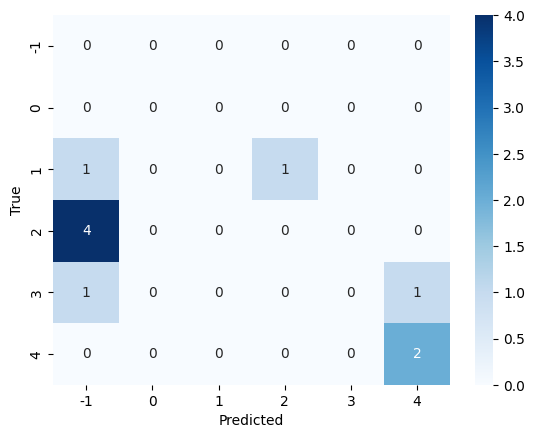

In [12]:
# 混同行列で結果を可視化
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 混同行列に使用するラベル作成
label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### few-shotプロンプトを使ったレビューの分類

In [ ]:
num_few_shot = 4  # few-shotで使用する回答例の数

# few-shotプロンプトに使用するデータ
review_list_few_shot = shuffled_dataset[k: k + num_few_shot]["text"]
label_list_few_shot = shuffled_dataset[k: k + num_few_shot]["label"]

print(review_list_few_shot)
print(label_list_few_shot)

In [ ]:
# few-shotプロンプトの作成

system_prompt = """
レビュー文を0から4までの整数に分類してください。
"""

few_shot_prompt = "### 例 ###\n"
for i in range(num_few_shot):
    few_shot_prompt += "レビュー文: " + review_list_few_shot[i]
    few_shot_prompt += "\n" + str(label_list_few_shot[i]) + "\n\n"
system_prompt += "\n" + few_shot_prompt

print(system_prompt)

In [ ]:
## few-shotプロンプトを用いたレビュー分類

# 使用するモデルの設定
model = "gpt-4o-mini-2024-07-18"

predict_label_list = []  # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(review_list, label_list)):
    # user_prompt = "レビュー文: " + review + "\n評価: "
    user_prompt = "レビュー文: " + review + "\n"
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(user_prompt)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(model, system_prompt, user_prompt)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")

In [ ]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

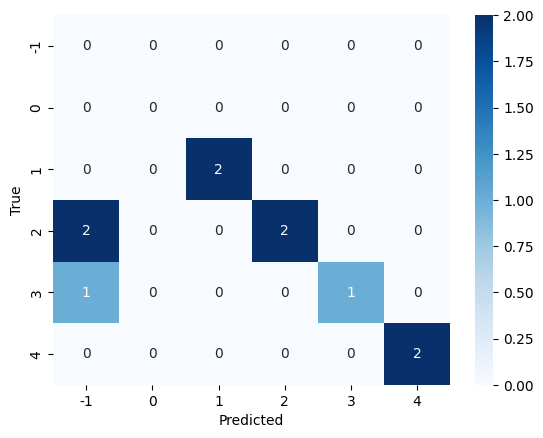

In [18]:
# 混同行列で結果を可視化

label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### テストデータを用いた評価

* few-shotプロンプトを用いてテストデータをレビュー分類
  * 検証データについてfew-shotプロンプトを用いた結果が良かったため

In [ ]:
test_review_list = shuffled_dataset[-k:]["text"]
test_label_list = shuffled_dataset[-k:]["label"]
print(test_review_list)
print(test_label_list)

In [ ]:
# テストデータで評価
## 最も良かったfew-shotプロンプトを使用

predict_label_list = [] # -1(出力形式のエラー), 0, 1, 2, 3, 4
total_credit = 0
for i, (review, label) in enumerate(zip(test_review_list, test_label_list)):
    # user_prompt = "レビュー文: " + review + "\n評価: "
    user_prompt = "レビュー文: " + review + "\n"
    print(f"\n^^^^^^^^^^ {i+1}件目のレビュー ^^^^^^^^^^")
    print("--- レビュー文 ---")
    print(user_prompt)
    print("--- 実際の評価 ---")
    print(label)
    response, credit = simple_completion(model, system_prompt, user_prompt)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    try:
        response_int = int(response.choices[0].message.content)
        predict_label_list.append(response_int)
    except ValueError:
        print("--- Error ---")
        print("回答がint型に変換できませんでした。")
        predict_label_list.append(-1)
        continue
print(f"合計金額: {total_credit}円")

In [ ]:
print("--- 実際の評価 ---")
print(test_label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)
## 予測した評価が-1（出力形式のエラー）の場合は+6

validation_score = 0 # 評価値
correct_answer = 0 # 正解数
for actual, predict in zip(test_label_list, predict_label_list):
    if not actual == predict:
        if predict == -1:
            validation_score += 6
            continue
        validation_score += abs(actual - predict)
    else:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(test_label_list)*100} %")
print("--- 評価値 (低いほうが良い結果) ---")
print(validation_score)

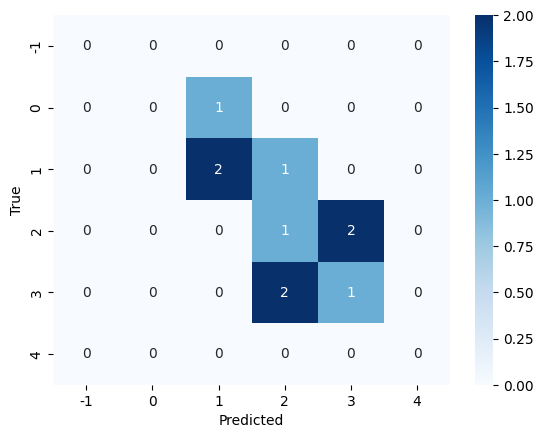

In [ ]:
# 混同行列で結果を可視化

label_name = list(range(-1, 5))  # [-1, 0, .., 4]

# 混同行列の作成
confusion_mtr = confusion_matrix(test_label_list, predict_label_list, labels=label_name)

# ラベル名
label_name = list(range(-1, 5))

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 演習課題例②: **ニュース記事からカテゴリ分類**

* Yahooニュースからニュース記事の概要、カテゴリを収集
  * スポーツ、経済の2カテゴリからランダムに
  * スポーツと経済のどちらにも該当するケースは選ばないように収集
  * 合わせて24記事収集 (スポーツ12記事、経済12記事)
  * Googleスプレッドシートを使用し、カテゴリ、文章の2つを手作業で記入

* ChatGPTによるカテゴリ分類
  * zero-shotプロンプトを使用した例
  * few-shotプロンプトを使用した例

### 記事の収集とデータの読み込み

* 各自で設定した課題に関するデータを収集してください

* 今回の例では、以下のリンクのスプレッドシートを作成したと想定する
  * https://docs.google.com/spreadsheets/d/1eJV-uRF1Mbpt_MokNfMvFewarMBsqWfM32W5_HdGvow/edit?usp=sharing

  * 以下より、スプレッドシートをダウンロード

<img src="https://drive.google.com/uc?export=view&id=1SdXP1PMFsQtkAgqyhlL-W9npfxYHJWGY" width=50%>


* ダウンロードしたデータをColab上にアップロード

<img src="https://drive.google.com/uc?export=view&id=1YVJhXYVCEehBF_li5EiWjUxiwKepnaFY" width=50%>

In [ ]:
SEED = 1000

# スプレッドシートの読み込み
df = pd.read_excel("yahoo_news_dataset.xlsx")  #TODO: ここを各々のデータに置き換える

df = df.sample(frac=1, random_state=SEED)  # データをシャッフル

df.head()

In [24]:
k = 10 # 10件のレビュー文に対する評価

# 検証データ
review_list = df[:k]["文章"].values.tolist()     # 入力文章が格納されている列名
label_list = df[:k]["カテゴリ"].values.tolist()  # カテゴリ、ラベルが格納されている列名

# few-shotデータ
num_few_shot = 4  # few-shotの数
review_list_few_shot = df[k: k + num_few_shot]["文章"].values.tolist()
label_list_few_shot = df[k: k + num_few_shot]["カテゴリ"].values.tolist()

# テストデータ
test_review_list = df[-k:]["文章"].values.tolist()
test_label_list = df[-k:]["カテゴリ"].values.tolist()

### 検証データによる評価

#### zero-shotプロンプトによるカテゴリ分類

* 検証データを用いたレビュー分類
* 回答例を与えないzero-shotプロンプトを使用

In [ ]:

# zero-shotプロンプト
system_prompt = """
文章を経済または、スポーツに分類してください。
'経済'もしくは'スポーツ'のどちらかで回答してください。
"""

# 使用するモデルの設定
model = "gpt-4o-mini-2024-07-18"

predict_label_list = []  # '経済', 'スポーツ'
total_credit = 0
for i, (text, label) in enumerate(zip(review_list, label_list)):
    # print(text)
    # print(label)
    # break
    print(f"\n^^^^^^^^^^ 記事{i+1} ^^^^^^^^^^")
    print("--- 文章 ---")
    print(text)
    print("--- 実際のカテゴリ ---")
    print(label)
    response, credit = simple_completion(model, system_prompt, text)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    predict_label_list.append(response.choices[0].message.content)
print(f"合計金額: {total_credit}円")

In [ ]:
print("--- 実際の評価 ---")
print(label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)

correct_answer = 0 # 正解数
for actual, predict in zip(label_list, predict_label_list):
    if actual == predict:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(label_list)*100} %")

In [ ]:
# 混同行列で結果を可視化
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 混同行列に使用するユニークなラベル作成
label_name = list(set(label_list + predict_label_list))  # ['経済', 'スポーツ']

# 混同行列の作成
confusion_mtr = confusion_matrix(label_list, predict_label_list, labels=label_name)

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

zero-shotプロンプトで良い精度だったので、このプロンプトでテストデータを評価

### テストデータを分類

In [ ]:
# zero-shotプロンプト
system_prompt = """
文章を経済または、スポーツに分類してください。
'経済'もしくは'スポーツ'のどちらかで回答してください。
"""

predict_label_list = []  # '経済', 'スポーツ'
total_credit = 0
for i, (text, label) in enumerate(zip(test_review_list, test_label_list)):
    # print(text)
    # print(label)
    # break
    print(f"\n^^^^^^^^^^ 記事{i+1} ^^^^^^^^^^")
    print("--- 文章 ---")
    print(text)
    print("--- 実際のカテゴリ ---")
    print(label)
    response, credit = simple_completion(model, system_prompt, text)
    total_credit += credit
    print("--- ChatGPTの回答 ---")
    print(response)
    print(response.choices[0].message.content)

    predict_label_list.append(response.choices[0].message.content)
print(f"合計金額: {total_credit}円")

In [ ]:
print("--- 実際の評価 ---")
print(test_label_list)
print("--- 予測した評価--- ")
print(predict_label_list)

# 評価
## 実際の評価と予測した評価の差の合計を評価値 (loss)

correct_answer = 0 # 正解数
for actual, predict in zip(test_label_list, predict_label_list):
    if actual == predict:
        correct_answer += 1
print("\n--- 正答率 ---")
print(f"{correct_answer/len(test_label_list)*100} %")

In [ ]:
# 混同行列に使用するユニークなラベル作成
label_name = list(set(test_label_list + predict_label_list))  # ['経済', 'スポーツ']

# 混同行列の作成
confusion_mtr = confusion_matrix(test_label_list, predict_label_list, labels=label_name)

# 混同行列を可視化
sns.heatmap(confusion_mtr, annot=True, fmt="d", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()